# DenseNet in Tensorflow (Functional API)

This notebook implements a DenseNet architecture in detail using the functional API. Additionally, I verify that the implemented architecture matches the official DenseNet121 pre-trained on imagenet by comparing their layers configurations and showing that if we copy the weights from the pre-trained model to my custom DenseNet121, the label predictions will be the same.

This should serve to help with understanding the computations involved without giving away the solution to the homework. You will need to translate this to the sub-classing API.

Recall the differences between the Functional API and the Sub-Classing API:

- In the functional API, you don't need an init in which we list all the layers that we will use

- In the subclassing API you need to define all the layers (and on a lower level the variables) that you use in the call method. Do not have excess layers in the init that you do not use in the call method.

- In the functional API, you can simply ignore the batch dimension in the operations that we do. Tensorflow/Keras take care of the batch dimension.

- In the subclassing API, you need to think about the batch dimension when writing the layers (especially important for concatenating two tensors within a layer).


In [32]:
import tensorflow as tf

In [33]:
def conv_block(x, n_filters, new_channels):
    
    """
    Instantiates the layers and computations involved in a Convolutional block. These are used to build
    dense blocks that are the main architectural building blocks of the DenseNet, together with transition layers.
    
    Args:
    x (KerasTensor) : Input to the block
    
    n_filters (int) : number of filters used within the block (does not have an effect on n of output channels)
    
    new_channels (int) : number of channels to be added to the input by the block
    """
    
    # batchnorm and relu
    x_out = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)(x)
    x_out = tf.keras.layers.Activation(tf.nn.relu)(x_out)
    
    # 1x1 convolution with 128 filters (padding "valid" because with 1x1 we don't need padding)
    x_out = tf.keras.layers.Conv2D(n_filters, 
                                   kernel_size=(1,1), 
                                   padding="valid",
                                  use_bias=False)(x_out)
    
    # batchnorm and relu
    x_out = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)(x_out)
    x_out = tf.keras.layers.Activation(tf.nn.relu)(x_out)
    
    # 3x3 convolution with 32 filters (to be concatenated with the input)
    x_out = tf.keras.layers.Conv2D(new_channels, kernel_size=(3,3), padding="same", use_bias=False)(x_out)
    
    
    # Concatenate layer (just a tf.keras.layers.Layer that calls tf.concat)
    x_out = tf.keras.layers.Concatenate(axis=3)([x, x_out]) # axis 3 for channel dimension
    
    return x_out

In [34]:
def dense_block(x, n_blocks):
    """
    Instantiates conv_block layers and applies their computations involved in a dense block for the functional
    API.
    """
    
    # use n different conv_blocks
    for _ in range(n_blocks):    
        
        x = conv_block(x, n_filters=128, new_channels=32)
        
    return x

In [35]:
def transition_layer(x):
    """
    Instantiates the layers and applies computations involved in a TransitionLayer 
    from DenseNet for the functional API.
    
    A transition layer is used to reduce the size of the feature maps and halve the number of feature maps.
    
    Args:
    x (KerasTensor) : Input to the transition layer
    """
    
    x = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)(x)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    
    # bottleneck, reducing the number of feature maps
    #(floor divide current number of filters by two for the bottleneck)
    reduce_filters_to = x.shape[-1] // 2 
    
    x = tf.keras.layers.Conv2D(filters = reduce_filters_to,
                               kernel_size=(1,1),
                               padding="valid",
                              use_bias=False)(x)
    
    # reduce the height and width of the feature map (not too useful for low-res input)
    
    x = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides = (2,2), padding = 'valid')(x)
        
    return x

# Showing a simplified DenseNet

Before we take a look at what a full DenseNet121 implementation looks like to appreciate why it is called Deep Learning, let's look at a strongly simplified version of a DenseNet Plotting the 429 layers of the DenseNet121 is probably not a good idea. So let's create a simplified version and just show one DenseBlock (with one convolutional block) followed by a transition layer.

The first part of the network is a simple convolutional layer followed by (unstrided) max pooling. For higher resolution images typically strided convolution followed by strided pooling is used to subsample the feature maps.

In [36]:
def get_simplified_densenet():
    x_in = tf.keras.Input((32,32,3))
    
    # before using the dense blocks, let's increase the number of feature maps. 
    # For high-res inputs we would also use strides=(2,2) to reduce the size of each feature map
    x = tf.keras.layers.Conv2D(filters = 64, 
                               kernel_size=(5,5), 
                               strides=(1,1),
                               padding="same",
                              use_bias=False)(x_in)
    
    x = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)(x)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1), padding="valid")(x)
    
    # use just a single conv-block followed by a transition layer
    x = dense_block(x, n_blocks=1)
    x = transition_layer(x)
    
    # Classification head
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x_out = tf.keras.layers.Dense(10,activation="softmax")(x)
    
    return tf.keras.Model(x_in, x_out)

simple_model = get_simplified_densenet()

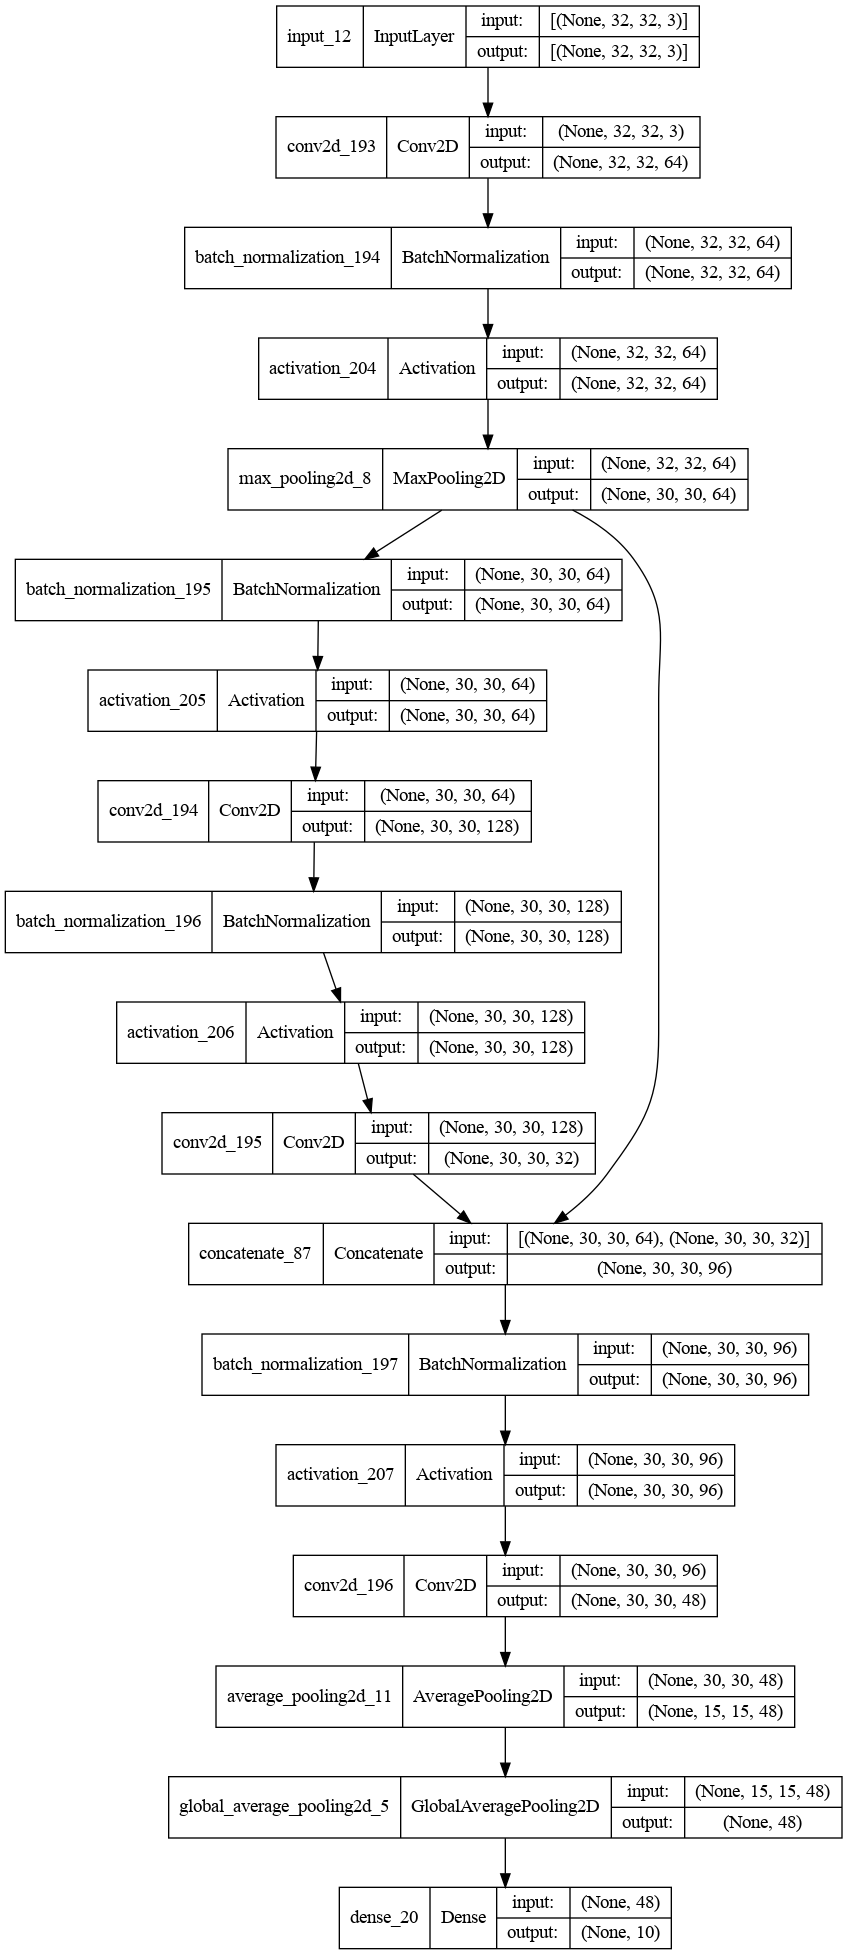

In [37]:
# plotting a model graph only works for functional API models
tf.keras.utils.plot_model(simple_model, show_shapes=True)

# The full DenseNet121

Below we will show what a complete DenseNet121 looks like and validate our implementation by copying the weights from a loaded official DenseNet121 that was trained on imagenet.

In [38]:
def get_DenseNet121():
    """
    Creates a tf.keras.Model with the functional API that matches the official DenseNet121 in detail.
    
    The architecture is as follows:
    
    (stem of the network)
    zero padding (3,3)
    7x7 conv with strides 2 (valid)

    batchnormalization
    
    relu
    
    zero padding (1,1)
    3x3 max pool, strides 2 (valid)
    
    (after reducing the input size, we now use our dense and transition blocks)
    
     6 Conv Blocks 
     
    Transition layer

    12 Conv Blocks
    
    Transition layer

    24 Conv Blocks
    
    Transition layer

    16 Conv Blocks

    batchnormalization
    
    relu

    global pooling 
    
    (having extracted the feature vector from the image with the 4 DenseBlocks, we apply the classification head)
    
    1000 units dense with softmax (because imagenet has 1000 classes)
    
    """
    # (pseudo input, not used for building subclassed models, only in functional api!)
    x_in = tf.keras.layers.Input(shape= (224,224,3)) # shape of imagenet images
    
    # the stem of the network (used to subsample the image, reducing the size of feature maps)
    # note this is not needed for low res images like in cifar10.
    
    # use extra zero padding because otherwise same padding would be asymmetric (we want it to be symmetric)
    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3), data_format=None)(x_in)
    
    x = tf.keras.layers.Conv2D(filters = 64, 
                               kernel_size=(7,7), 
                               strides=(2,2),
                               padding="valid",
                              use_bias=False)(x)
    
    x = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)(x)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    
    # use extra zero padding because otherwise same padding would be asymmetric (we want it to be symmetric)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1), data_format=None)(x)
    
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid")(x)
    
    
    # 6 conv blocks forming the first dense block
    x = dense_block(x, n_blocks=6)
    
    # Transition layer to reduce resolution and halve number of feature maps
    x = transition_layer(x)
    
    # 12 conv blocks forming the second Dense block
    
    x = dense_block(x, n_blocks=12)
    
    # Transition layer to reduce resolution and halve number of feature maps
    x = transition_layer(x)
    
    # 24 conv blocks forming the third Dense Block
    
    x = dense_block(x, 24)
        
    x = transition_layer(x)
    
    # Another dense block with 16 conv blocks
    x = dense_block(x, 16)
        
    # this was the last dense block, so we now apply bn and relu
    
    x = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)(x)
    x = tf.keras.layers.Activation(tf.nn.relu)(x)
    
    # By now, the feature maps are only 7x7 in height and width. 
    # We use global average pooling to transform them into feature vectors that work with Dense Layers.
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Classification head (imagenet has 1000 classes, which means 1000 output units with softmax)
    
    x_out = tf.keras.layers.Dense(1000, activation="softmax")(x)
    
    return tf.keras.Model(x_in, x_out)

# Comparing the custom implementation with the official implementation

To check whether my DenseNet121 is implemented correctly, I will compare it with the DenseNet121 from tf.keras.applications, which is pre-trained on imagenet (more on transfer learning later in this course!)

In [39]:
# instantiate our custom DenseNet121
custom_dense_net = get_DenseNet121()
custom_dense_net.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_13[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_197 (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                          

In [40]:
# Download and load the official DenseNet121 model
pre_trained_dense_net = tf.keras.applications.DenseNet121()
pre_trained_dense_net.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 230, 230, 3)  0          ['input_14[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_12[0][0]']      
                                )                                                       

In [41]:
# check if all layers have the same configuration

for layer, layer2 in zip(pre_trained_dense_net.layers, custom_dense_net.layers):
    # get configurations of layers
    cfg = layer.get_config()
    cfg2 = layer2.get_config()
    # get rid of name attribute (since they are different between our models)
    del cfg["name"]
    del cfg2["name"]
    
    # check if config is the same, if not, print the layers and their configs
    if cfg != cfg2:
        print("Layers were instantiated with different arguments!")
        print(layer, layer2)
        print(cfg, "\n\n", cfg2, "\n\n\n")

Now that we've seen that the two models have the exact same layer configurations, let's find out if we can make our custom model give the same predictions as the pre-trained model by copying the weights!

Note that this only works if the model architectures are exactly equivalent!

In [42]:
custom_dense_net.set_weights(pre_trained_dense_net.weights)

data = tf.random.normal((32,224,224,3))

# The pre-trained DenseNet requires its own preprocessing, so we apply it to our random images batch
data = tf.keras.applications.densenet.preprocess_input(data, data_format=None)

custom_output = custom_dense_net(data)

official_output = pre_trained_dense_net(data)

print(f"The predictions of the two models are the exact same: {tf.reduce_all(custom_output == official_output)}")

The predictions of the two models are the exact same: True


# Task for homework: 

- Implement a DenseBlock and a Transition layer similar to the above by subclassing tf.keras.layers.Layer and use it to build a model that uses this custom layer and is subclassed from tf.keras.Model with a custom train and validation loop. Note that unlike with the DenseNet121 you may not want to have as much of a reduction in feature map size (since the dataset is already of low resolution images). So you don't want as much striding in the "stem" part of the network.